In [19]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import feasibility_helpers
from sklearn import neighbors
import os
import math
import json

Input

In [20]:
################################################################################
#==============================================================================#
##########################Eq analyze input######################################
date = '10-7-2023-Fe-Cr-Ni-C-Cr-Cu-Fe-Mo-Nb-Ni-03-29'
allowed_phases = ['LIQUID','BCC', 'FCC', 'HCP'] #as long as BCC is in the phase name, it's good, e.g. BCC_B2, BCC_A2, can change in the findMaxUnallowedPhase() function
threshold_Eq = 0.1 # 
plotEqfeasibilityMap = False
plotEqfeasibilityMap_diffR = False
plotEqPhaseHeatMap = False
plotEqPhaseHeatMap_combined = False

In [21]:
################################################################################
#==============================================================================#
##############################get settings######################################
settings = np.load(f'./Simulation/{date}/setting.npy',allow_pickle=True)
TRange = settings[0]
numFile = int(settings[1])
comp1 = settings[5][0]
comp2 = settings[5][1]
comps = settings[4]
folder_Eq = f'./Simulation/{date}/Equilibrium Simulation'
isExist = os.path.exists(folder_Eq + '/Result')
if not isExist:
    os.makedirs(folder_Eq + '/Result')
    print("The new directory is created!")
# folder_Scheil = f'./Simulation/{date}/Scheil Simulation'
# isExist = os.path.exists(folder_Scheil + '/Result')
# if not isExist:
#     os.makedirs(folder_Scheil + '/Result')
#     print("The new directory is created!")
#get composition
data = pd.read_excel(f'./Simulation/{date}/composition_for_feasibilityMap.xlsx')
composition_data = dict()
for item in data.columns:
    if 'alloy' in item:
        composition_data[item[6:]] = data[item].values.tolist()[:numFile]
composition_data = pd.DataFrame(composition_data)

In [22]:
################################################################################
#==============================================================================#
############################Scheil script#######################################
database = settings[-2]
output_Scheil = f'{comps[0]}-{comps[1]}-{comps[2]}-Scheil'
backupStartTemp = 1600
temperatureStep = 1
iterationNum = 500
finalLiquidFraction = 0.001
maxNumSim = 300  # maximum number of simulations in each TCM file
GlobalMinimization = True
miscibilityGap = False # not ready for use yet
miscibilityGapPhase = 'LIQUID'
fastDiffusing = False
fastDiffusingComp = 'C'
retainPhase = False #False = consider all phase within the elements system; True = only consider the following phases
if retainPhase:
    Phases = 'FCC_A1 BCC_A2 LIQUID' # 'LIQUID FCC_A1 ORD_FCC BCC_A2 DELTA LAVES' #'LIQUID BCC_A2 FCC_A1 HCP_A3 SIGMA LAVES_PHASE_C14 NBNI3 P_PHASE MU_PHASE'
rejectPhase = False #False = consider all phase within the elements system; True = reject the following phases
if rejectPhase:
    Phases = 'DICTRA_FCC_A1'
# rejectPhase and retainPhase, only one of them can be true

Step1: 
Read Eq Result--phase, composition data

In [23]:
def getColumn(words):
    columns = []
    for word in words:
        try:
            index1 = word.index('(') + 1
            index2 = word.index(')')
            columns.append(word[index1:index2])
        except:
            index1 = word.index('=') + 1
            columns.append(word[index1:-1])
    return columns

def sortOutputbyT(output,T):
    n = len(output[T])
    for i in range(n):
        # Last i elements are already in place
        for j in range(0, n-i-1):
            # Traverse the array from 0 to n-i-1
            # Swap if the element found is greater than the next element
            if output[T][j] > output[T][j+1] :
                for item in output.keys():
                    output[item][j], output[item][j+1] = output[item][j+1], output[item][j]
    return output

def readEqFromFile(file_index, Mole = True):
    if Mole:
        fileName = f'{folder_Eq}/{file_index}_mole.exp'
    else:
        fileName = f'{folder_Eq}/{file_index}_wt.exp'
    f = open(fileName,'r+')
    lines = f.readlines()
    #############get all col###########
    columns = []
    for index in range(len(lines)):
        content = lines[index]
        words = content.split()
        if len(words) > 0 and 'col-1=' in words[0]:
            columns += getColumn(words)
    finalcolumns = set(columns)
    ############initialize output######
    output = dict()
    for item in finalcolumns:
        output[item] = []
    ###################################
    startRead = False
    for index in range(len(lines)):
        content = lines[index]
        words = content.split()
        if len(words) > 0 and 'col-1=' in words[0]:
            columns = getColumn(words)
            startRead = True
        if startRead and len(words) > 0 and 'col-1=' not in words[0]:
            if len(words) == len(columns) and 'NONE' not in words:
                for col in finalcolumns:
                    if col in columns:
                        colIndex = columns.index(col)
                        output[col].append(float(words[colIndex]))
                    else:
                        output[col].append(0)
            else:
                print(f'error in {file_index}th file, line {index}')
        if startRead and len(words) == 0:
            startRead = False
        output = sortOutputbyT(output, columns[0])
    return output

def getdata():
    failList = []
    data_original = []
    data = []
    for index in tqdm(range(numFile)):
        try:
            Result_original = readEqFromFile(index, Mole = True)
            Result = {}
            for key in Result_original.keys():
                if ',' not in key:
                    Result[key] = Result_original[key]
            if Result == {} or Result_original == {}:
                print(f'error in {index}th file, no result!')
                data_original.append('None')
                data.append('None')
                failList.append(index)
            else:
                data_original.append(Result_original)
                data.append(Result)
        except Exception as e:
            print(f'fail to read {index}th file, {e}!')
            data_original.append('None')
            data.append('None')
            failList.append(index)
    return data, data_original, failList

data_Phase, data_withComp, failList = getdata()
print(f'{len(failList)} files failed. FailList:')
print(failList)

100%|██████████| 903/903 [00:00<00:00, 6359.16it/s]

fail to read 0th file, [Errno 2] No such file or directory: './Simulation/10-7-2023-Fe-Cr-Ni-C-Cr-Cu-Fe-Mo-Nb-Ni-03-29/Equilibrium Simulation/0_mole.exp'!
fail to read 1th file, [Errno 2] No such file or directory: './Simulation/10-7-2023-Fe-Cr-Ni-C-Cr-Cu-Fe-Mo-Nb-Ni-03-29/Equilibrium Simulation/1_mole.exp'!
fail to read 2th file, [Errno 2] No such file or directory: './Simulation/10-7-2023-Fe-Cr-Ni-C-Cr-Cu-Fe-Mo-Nb-Ni-03-29/Equilibrium Simulation/2_mole.exp'!
fail to read 3th file, [Errno 2] No such file or directory: './Simulation/10-7-2023-Fe-Cr-Ni-C-Cr-Cu-Fe-Mo-Nb-Ni-03-29/Equilibrium Simulation/3_mole.exp'!
fail to read 4th file, [Errno 2] No such file or directory: './Simulation/10-7-2023-Fe-Cr-Ni-C-Cr-Cu-Fe-Mo-Nb-Ni-03-29/Equilibrium Simulation/4_mole.exp'!
fail to read 5th file, [Errno 2] No such file or directory: './Simulation/10-7-2023-Fe-Cr-Ni-C-Cr-Cu-Fe-Mo-Nb-Ni-03-29/Equilibrium Simulation/5_mole.exp'!
fail to read 6th file, [Errno 2] No such file or directory: './Simulat

Save data in the nearest neightbor models

In [24]:
def trainEqNNModels():
    n_neighbors = 2
    weights = 'distance'
    PhaseNames = []
    Models = []
    for ii in tqdm(range(numFile)):
        if ii not in failList:
            Result = data_Phase[ii]
            try:
                input = np.array(Result['TC']).reshape(-1, 1) #note, should change this to 'TC' later
            except:
                input = np.array(Result['T']).reshape(-1, 1)
            output = []
            currphaseNames = []
            for phase in Result.keys():
                if phase != 'T' and phase != 'TC':
                    currphaseNames.append(phase)
                    output.append(Result[phase])
            PhaseNames.append(currphaseNames)
            output2 = []
            for index in range(len(output[0])):
                tempt = []
                for item in output:
                    tempt.append(item[index])
                output2.append(tempt)
            output = np.array(output2)
            model = neighbors.KNeighborsRegressor(n_neighbors, weights=weights).fit(input, output2)
            Models.append(model)
        else:
            Models.append('None')
            PhaseNames.append('None')
    return Models, PhaseNames
Models, PhaseNames = trainEqNNModels()
np.save(f'{folder_Eq}/Result/Models.npy',Models)
np.save(f'{folder_Eq}/Result/PhaseNames.npy',PhaseNames)

100%|██████████| 903/903 [00:00<00:00, 225820.21it/s]


Optional: get Eq result at a specific temperature and save it into a json file

In [25]:
import json
def outputDataAtT(Models, PhaseNames, T, numFile):
    result = dict()
    for index in range(numFile):
        point = dict()
        phases = PhaseNames[index]
        if phases != 'None':
            for phase in phases:
                point[phase] = Models[index].predict(np.array([T]).reshape(-1, 1))[0][phases.index(phase)]
        result[index] = point
    outputFile = json.dumps(result)
    f = open(f'{folder_Eq}/Result/Phase_{T}C.json','w')
    f.write(outputFile)
    f.close()
    print('Saved!')
    return result
outputDataAtT(Models, PhaseNames, 800, numFile)

Saved!


{0: {},
 1: {},
 2: {},
 3: {},
 4: {},
 5: {},
 6: {},
 7: {},
 8: {},
 9: {},
 10: {},
 11: {},
 12: {},
 13: {},
 14: {},
 15: {},
 16: {},
 17: {},
 18: {},
 19: {},
 20: {},
 21: {},
 22: {},
 23: {},
 24: {},
 25: {},
 26: {},
 27: {},
 28: {},
 29: {},
 30: {},
 31: {},
 32: {},
 33: {},
 34: {},
 35: {},
 36: {},
 37: {},
 38: {},
 39: {},
 40: {},
 41: {},
 42: {},
 43: {},
 44: {},
 45: {},
 46: {},
 47: {},
 48: {},
 49: {},
 50: {},
 51: {},
 52: {},
 53: {},
 54: {},
 55: {},
 56: {},
 57: {},
 58: {},
 59: {},
 60: {},
 61: {},
 62: {},
 63: {},
 64: {},
 65: {},
 66: {},
 67: {},
 68: {},
 69: {},
 70: {},
 71: {},
 72: {},
 73: {},
 74: {},
 75: {},
 76: {},
 77: {},
 78: {},
 79: {},
 80: {},
 81: {},
 82: {},
 83: {},
 84: {},
 85: {},
 86: {},
 87: {},
 88: {},
 89: {},
 90: {},
 91: {},
 92: {},
 93: {},
 94: {},
 95: {},
 96: {},
 97: {},
 98: {},
 99: {},
 100: {},
 101: {},
 102: {},
 103: {},
 104: {},
 105: {},
 106: {},
 107: {},
 108: {},
 109: {},
 110: {},


Step2: Read Eq result--maximum phase amount

In [26]:
######################Get Eq result in all temperature range##################
def findMaxUnallowedPhase(Point):
    keys = []
    for item in Point.keys():
        if item != 'T' and item != 'TC':
            keys.append(item)
    allowedphaseNames = []
    for item in keys:
        for name in allowed_phases:
            if name in item:
                allowedphaseNames.append(item)
    result = []
    for index in range(len(Point[keys[0]])):
        total = 0
        for item in allowedphaseNames:
            total += Point[item][index]
        result.append(total)
    minAllowedPhaseAmount = min(result)
    return 1 - minAllowedPhaseAmount

def getResult():
    result = []
    print('Get Eq feasibility at all T:')
    for index in tqdm(range(numFile)):
        x = composition_data[comp1].values[index]
        y = composition_data[comp2].values[index]
        if index not in failList:
            phaseResult = data_Phase[index]
            try:
                maxAmount = findMaxUnallowedPhase(phaseResult)
                result.append((x, y, maxAmount))
            except:
                print(f'failed for {index}:',data[index])
                result.append((x, y, None))
        else:
            result.append((x, y, None))
    np.save(f'{folder_Eq}/Result/unallowed_Eq_nonDynamic.npy',result)
if plotEqfeasibilityMap:
    getResult()
################################################################################
#==============================================================================#
#########################Get Eq result in at each temperature###################
def findMaxUnallowedPhase_EachT(Point):
    keys = []
    for item in Point.keys():
        if item != 'T' and item != 'TC':
            keys.append(item)
    allowedphaseNames = []
    for item in keys:
        for name in allowed_phases:
            if name in item:
                allowedphaseNames.append(item)
    result = []
    total = 0
    for item in allowedphaseNames:
        total += Point[item]
    result.append(total)
    minAllowedPhaseAmount = min(result)
    return 1 - minAllowedPhaseAmount

def getResul_T():
    print('Get Eq feasibility at Different T:')
    for T in tqdm(range(TRange[0], TRange[1], TRange[2])):
        result = []
        for index in range(numFile):
            x = composition_data[comp1].values[index]
            y = composition_data[comp2].values[index]
            if index not in failList:
                phases = PhaseNames[index]
                phaseAmounts = Models[index].predict(np.array([T]).reshape(1, -1))
                phaseResult = {}
                for i in range(len(phases)):
                    phaseResult[phases[i]] = phaseAmounts[0][i]
                try:
                    maxAmount = findMaxUnallowedPhase_EachT(phaseResult)
                    result.append((x, y, maxAmount))
                except:
                    print(f'failed for {index}:',data[index])
                    result.append((x, y, None))
            else:
                result.append((x, y, None))
        if not os.path.exists(f'{folder_Eq}/Result/Different_T'):
            os.makedirs(f'{folder_Eq}/Result/Different_T')
        np.save(f'{folder_Eq}/Result/Different_T/{T}_unallowed.npy',result)
if plotEqfeasibilityMap_diffR:
    getResul_T()
################################################################################
#==============================================================================#
################Get Eq phase amount at different temperatures###################
def getEqPhaseAmountAtDiffT(Model = Models, phaseNames = PhaseNames):
    Phase_diffT = {}
    print('Get Phase Amount at Different T:')
    for T in tqdm(range(TRange[0], TRange[1], TRange[2])):
        currTResult = {}
        for index in range(numFile):
            x = composition_data[comp1].values[index]
            y = composition_data[comp2].values[index]
            if index not in failList:
                phases = PhaseNames[index]
                phaseAmounts = Models[index].predict(np.array([T]).reshape(1, -1))[0]
                nonZeroPhases = []
                nonZeroPhaseAmounts = []
                for i in range(len(phaseAmounts)):
                    amount = phaseAmounts[i]
                    if amount != 0:
                        nonZeroPhases.append(phases[i])
                        nonZeroPhaseAmounts.append(phaseAmounts[i])
                for i in range(len(nonZeroPhases)):
                    phase = nonZeroPhases[i]
                    if phase in currTResult.keys():
                        currTResult[phase].append((x,y,nonZeroPhaseAmounts[i]))
                    else:
                        currTResult[phase] = [(x,y,nonZeroPhaseAmounts[i])]
        Phase_diffT[T] = currTResult
    output = json.dumps(Phase_diffT)
    f = open(f'{folder_Eq}/Result/EqPhaseHeatMap.json','w')
    f.write(output)
    f.close()
    return Phase_diffT

if plotEqPhaseHeatMap:
    Phase_diffT = getEqPhaseAmountAtDiffT(Model = Models, phaseNames = PhaseNames)
################################################################################
#==============================================================================#
###########Get Eq phase amount at different temperatures (combined)#############

def getEqPhaseAmountAtDiffT_combined(Model = Models, phaseNames = PhaseNames):
    Phase_diffT_combined = {}
    print('Get Combined Phase Amount at Different T:')
    for T in tqdm(range(TRange[0], TRange[1], TRange[2])):
        currTResult = {}
        for index in range(numFile):
            x = composition_data[comp1].values[index]
            y = composition_data[comp2].values[index]
            if index not in failList:
                phases = PhaseNames[index]
                phaseAmounts = Models[index].predict(np.array([T]).reshape(1, -1))[0]
                nonZeroPhases = []
                nonZeroPhaseAmounts = []
                for i in range(len(phaseAmounts)):
                    amount = phaseAmounts[i]
                    if amount != 0:
                        nonZeroPhases.append(phases[i])
                        nonZeroPhaseAmounts.append(phaseAmounts[i])
                simplePhase = []
                for phase in nonZeroPhases:
                    if '#' not in phase:
                        simplePhase.append(phase)
                    else:
                        simplePhase.append(phase[:phase.index('#')])
                simplePhase = [item for item in set(simplePhase)]
                
                for phase in simplePhase:
                    phaseAmount = 0
                    i = 0
                    for allPhase in nonZeroPhases:
                        if phase in allPhase:
                            phaseAmount += nonZeroPhaseAmounts[i]
                        i += 1
                    if phase in currTResult.keys():
                        currTResult[phase].append((x,y,phaseAmount))
                    else:
                        currTResult[phase] = [(x,y,phaseAmount)]
        Phase_diffT_combined[T] = currTResult
    output = json.dumps(Phase_diffT_combined)
    f = open(f'{folder_Eq}/Result/EqPhaseHeatMap_combined.json','w')
    f.write(output)
    f.close()
    return Phase_diffT_combined
if plotEqPhaseHeatMap_combined:
    Phase_diffT_combined = getEqPhaseAmountAtDiffT_combined(Model = Models, phaseNames = PhaseNames)

In [27]:
# #tempt
# np.save('Fe-Cr-Ni-Eq1300.npy',Phase_diffT_combined[1300])


Step3: Plot Equilibrium feasibility Map

In [28]:
indep_comp_vars = [comp1, comp2]
handles = [
    mpl.patches.Patch(facecolor='red'),
    mpl.patches.Patch(facecolor='green'),
    mpl.patches.Patch(facecolor='black')
]
labels = [
    'Equilibrium infeasible',
    'Equilibrium feasible',
    'No Result'
]
coord = []
for index in range(len(composition_data)):
    x = composition_data[comp1].values[index]
    y = composition_data[comp2].values[index]
    coord.append((x, y))

In [29]:
def plotNonDynamicEq():
    dotSize = 8
    # plt.style.use('papers.mplstyle')
    # Plot feasibility on a ternary triangular diagram
    fig = plt.figure(figsize = (3,3), dpi = 500)
    # result = [] #(x,y,eq_phase, scheil_phase)
    ax = fig.add_subplot(projection='triangular')
    for i in range(numFile):
        x_plot = coord[i][0]
        y_plot = coord[i][1]
        ax.scatter(x_plot, y_plot,s = dotSize, c='black')

    plt.xticks([],[])
    plt.yticks([],[])
    fig.savefig(f'test.tif', bbox_inches='tight')
    plt.close()
if plotEqfeasibilityMap:
    plotNonDynamicEq()

In [30]:
dotSize = 12

In [31]:
################################################################################
#==============================================================================#
######################Plot Non-dynamic Equlibrium feasibility map###############
def plotNonDynamicEq():
    # plt.style.use('papers.mplstyle')
    # Plot feasibility on a ternary triangular diagram
    fig = plt.figure(figsize = (3,3), dpi = 200)
    # result = [] #(x,y,eq_phase, scheil_phase)
    ax = fig.add_subplot(projection='triangular')
    result = np.load(f'{folder_Eq}/Result/unallowed_Eq_nonDynamic.npy', allow_pickle=True) 
    for x_plot, y_plot,eq_phase in result:
        if eq_phase != None:
            eq_is_feasible = eq_phase < threshold_Eq

            if not eq_is_feasible:
                ax.scatter(x_plot, y_plot,s = dotSize, label='Equilibrium infeasible', c='red')
                continue

            if eq_is_feasible:
                ax.scatter(x_plot, y_plot, s = dotSize, label='Equilibrium feasible', c='green')
                continue
        else:
            ax.scatter(x_plot, y_plot, s = dotSize, label='No Result', c='black')
    fmtted_comps = '-'.join(sorted(set(comps)))

    # result = np.array(result)

    ax.set_title(f"{fmtted_comps}\nTolerance: {threshold_Eq}\n{TRange[0]}-{TRange[1]}-{TRange[2]}", fontname = 'Calibri', fontsize = 11)
    ax.set_xlabel(f'W({comp1})', fontname = 'Calibri', fontsize = 11)
    ax.set_ylabel(f'W({comp2})', labelpad=-30, fontname = 'Calibri', fontsize = 11)
    fig.legend(handles=handles, labels=labels, loc='lower left',prop={'family':'Calibri', 'size':11}, bbox_to_anchor=(0.55, 0.65),labelspacing=0.1,handletextpad=0)
    ax.set_xticks([0,0.2,0.4,0.6,0.8,1],[0,0.2,0.4,0.6,0.8,1],fontname = 'Calibri', fontsize = 11)
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1],[0,0.2,0.4,0.6,0.8,1],fontname = 'Calibri', fontsize = 11)

    fig.savefig(f'{folder_Eq}/Result/{fmtted_comps}-Eq-nondynamic.tif', bbox_inches='tight')
    plt.close()
if plotEqfeasibilityMap:
    plotNonDynamicEq()


In [32]:
################################################################################
#==============================================================================#
################Plot Eq feasibility map at different temperatures###############
def plotEqDifferentT():
    for T in tqdm(range(TRange[0], TRange[1], TRange[2])):
        fig = plt.figure(figsize = (3,3),dpi=200)
        # result = [] #(x,y,eq_phase, scheil_phase)
        ax = fig.add_subplot(projection='triangular')
        result = np.load(f'{folder_Eq}/Result/Different_T\{T}_unallowed.npy',allow_pickle=True)
        for x_plot, y_plot,eq_phase in result:
            if eq_phase != None:
                eq_is_feasible = eq_phase < threshold_Eq
                

                # if eq_is_feasible and scheil_is_feasible:
                #     ax.scatter(x_plot, y_plot, label='Feasible', c='green')
                #     continue
                
                if not eq_is_feasible:
                    ax.scatter(x_plot, y_plot,s = dotSize, label='Equilibrium infeasible', c='red')
                else:
                    ax.scatter(x_plot, y_plot,s = dotSize, label='Both Feasible', c='green')
            else:
                ax.scatter(x_plot, y_plot,s = dotSize, label='No Result', c='black')

        fmtted_comps = '-'.join(sorted(set(comps)))

        # result = np.array(result)

        ax.set_title(f"{fmtted_comps}\nTolerance: {threshold_Eq}\nT = {T} $^\circ$C")
        ax.set_xlabel(f'X({comp1})',fontname = 'Calibri', fontsize = 11)
        ax.set_ylabel(f'X({comp2})', labelpad=-30,fontname = 'Calibri', fontsize = 11)
        fig.legend(handles=handles, labels=labels, loc='lower left',prop={'family':'Calibri', 'size':11}, bbox_to_anchor=(0.55, 0.65),labelspacing=0.1,handletextpad=0)
        ax.set_xticks([0,0.2,0.4,0.6,0.8,1],[0,0.2,0.4,0.6,0.8,1],fontname = 'Calibri', fontsize = 11)
        ax.set_yticks([0,0.2,0.4,0.6,0.8,1],[0,0.2,0.4,0.6,0.8,1],fontname = 'Calibri', fontsize = 11)
        if not os.path.exists(f'{folder_Eq}/Result/Different_T_feasibilityMap'):
            os.makedirs(f'{folder_Eq}/Result/Different_T_feasibilityMap')
        fig.savefig(f'{folder_Eq}/Result/Different_T_feasibilityMap\{fmtted_comps}-{T}.tif', bbox_inches='tight')
        plt.close()
if plotEqfeasibilityMap_diffR:
    plotEqDifferentT()

In [33]:
################################################################################
#==============================================================================#
###############Plot Eq phase heat map at different temperatures#################
if plotEqPhaseHeatMap:
    f = open(f'{folder_Eq}/Result/EqPhaseHeatMap.json')
    phase_DiffT = json.load(f)
def plotEqPhaseHeatMap_func():
    for T in tqdm(range(TRange[0], TRange[1], TRange[2])):
        phaseAmounts = phase_DiffT[str(T)]
        phaseNum = len(phaseAmounts.keys())
        fig = plt.figure(figsize = (3 * phaseNum,3),dpi=200)
        grid = plt.GridSpec(1, phaseNum,figure = fig)
        i = 0
        for phase in phaseAmounts.keys():
            # result = [] #(x,y,eq_phase, scheil_phase)
            ax = plt.subplot(grid[0,i], projection='triangular')
            getMaxAmount = []
            for x, y,amount in phaseAmounts[phase]:
                getMaxAmount.append(amount)
            maxAmount = max(getMaxAmount)
            norm = mpl.colors.Normalize(vmin = 0, vmax = maxAmount)
            goodPhase = False
            for item in allowed_phases:
                if item in phase:
                    goodPhase = True
            for x, y,amount in phaseAmounts[phase]:
                if goodPhase:
                    cmap = 'Greys'
                    RGB1 = mpl.cm.Greys(norm(amount), bytes = True) # matplotlib.cm.coolwarm_r(norm(value), bytes = True) #(ratio,ratio,ratio)
                    RGB = (RGB1[0]/255,RGB1[1]/255,RGB1[2]/255)
                else:
                    cmap = 'Reds'
                    RGB1 = mpl.cm.Reds(norm(amount), bytes = True) # matplotlib.cm.coolwarm_r(norm(value), bytes = True) #(ratio,ratio,ratio)
                    RGB = (RGB1[0]/255,RGB1[1]/255,RGB1[2]/255)
                ax.scatter(x, y, color = RGB, marker = "o", s = dotSize)
                    
            fmtted_comps = '-'.join(sorted(set(comps)))
            
            cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                orientation='horizontal',fraction=0.035, pad=0.2,aspect=20)
            for t in cbar.ax.get_xticklabels():
                t.set_fontsize(11)
                t.set_fontname('Calibri')
            # result = np.array(result)

            ax.set_title(f"{phase} at {T} $^\circ$C",fontname = 'Calibri', fontsize = 11)
            ax.set_xlabel(f'X({comp1})', labelpad=0,fontname = 'Calibri', fontsize = 11)
            ax.set_ylabel(f'X({comp2})', labelpad=-22,fontname = 'Calibri', fontsize = 11)
            ax.set_xticks([0,0.2,0.4,0.6,0.8,1],[0,0.2,0.4,0.6,0.8,1],fontname = 'Calibri', fontsize = 11)
            ax.set_yticks([0,0.2,0.4,0.6,0.8,1],[0,0.2,0.4,0.6,0.8,1],fontname = 'Calibri', fontsize = 11)
            i += 1
        if not os.path.exists(f'{folder_Eq}/Result/Different_T_phaseHeatMap'):
            os.makedirs(f'{folder_Eq}/Result/Different_T_phaseHeatMap')
        fig.savefig(f'{folder_Eq}/Result/Different_T_phaseHeatMap\{T}.tif', bbox_inches='tight')
        plt.close()
if plotEqPhaseHeatMap:
    plotEqPhaseHeatMap_func()

In [34]:
################################################################################
#==============================================================================#
#######Plot Eq phase heat map at different temperatures (combined phase)########
if plotEqPhaseHeatMap_combined:
    f = open(f'{folder_Eq}/Result/EqPhaseHeatMap_combined.json')
    Phase_diffT_combined = json.load(f)


def plotEqPhaseHeatMap_Combined():
    for T in tqdm(range(TRange[0], TRange[1], TRange[2])):
        phaseAmounts = Phase_diffT_combined[str(T)]
        phaseNum = len(phaseAmounts.keys())
        fig = plt.figure(figsize = (3 * phaseNum,3),dpi=200)
        grid = plt.GridSpec(1, phaseNum,figure = fig)
        i = 0
        for phase in phaseAmounts.keys():
            # result = [] #(x,y,eq_phase, scheil_phase)
            ax = plt.subplot(grid[0,i], projection='triangular')
            getMaxAmount = []
            for x, y,amount in phaseAmounts[phase]:
                getMaxAmount.append(amount)
            maxAmount = max(getMaxAmount)
            norm = mpl.colors.Normalize(vmin = 0, vmax = maxAmount)
            goodPhase = False
            for item in allowed_phases:
                if item in phase:
                    goodPhase = True
            for x, y,amount in phaseAmounts[phase]:
                if goodPhase:
                    cmap = 'Greys'
                    RGB1 = mpl.cm.Greys(norm(amount), bytes = True) # matplotlib.cm.coolwarm_r(norm(value), bytes = True) #(ratio,ratio,ratio)
                    RGB = (RGB1[0]/255,RGB1[1]/255,RGB1[2]/255)
                else:
                    cmap = 'Reds'
                    RGB1 = mpl.cm.Reds(norm(amount), bytes = True) # matplotlib.cm.coolwarm_r(norm(value), bytes = True) #(ratio,ratio,ratio)
                    RGB = (RGB1[0]/255,RGB1[1]/255,RGB1[2]/255)
                ax.scatter(x, y, color = RGB, marker = "o", s = dotSize)
                    
            fmtted_comps = '-'.join(sorted(set(comps)))
            
            cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                orientation='horizontal',fraction=0.035, pad=0.2,aspect=20)
            for t in cbar.ax.get_xticklabels():
                t.set_fontsize(11)
                t.set_fontname('Calibri')
            # result = np.array(result)

            ax.set_title(f"{phase} at {T} $^\circ$C",fontname = 'Calibri', fontsize = 11)
            ax.set_xlabel(f'X({comp1})', labelpad=0,fontname = 'Calibri', fontsize = 11)
            ax.set_ylabel(f'X({comp2})', labelpad=-22,fontname = 'Calibri', fontsize = 11)
            ax.set_xticks([0,0.2,0.4,0.6,0.8,1],[0,0.2,0.4,0.6,0.8,1],fontname = 'Calibri', fontsize = 11)
            ax.set_yticks([0,0.2,0.4,0.6,0.8,1],[0,0.2,0.4,0.6,0.8,1],fontname = 'Calibri', fontsize = 11)
            i += 1
        if not os.path.exists(f'{folder_Eq}/Result/Different_T_phaseHeatMap(combined phase)'):
            os.makedirs(f'{folder_Eq}/Result/Different_T_phaseHeatMap(combined phase)')
        fig.savefig(f'{folder_Eq}/Result/Different_T_phaseHeatMap(combined phase)\{T}.tif', bbox_inches='tight')
        plt.close()
if plotEqPhaseHeatMap_combined:
    plotEqPhaseHeatMap_Combined()

In [35]:
################################################################################
#==============================================================================#
#######Plot Eq phase heat map at different temperatures (combined phase)########
if plotEqPhaseHeatMap_combined:
    f = open(f'{folder_Eq}/Result/EqPhaseHeatMap_combined.json')
    Phase_diffT_combined = json.load(f)


def plotEqPhaseHeatMap_Combined():
    for T in tqdm(range(TRange[0], TRange[1], TRange[2])):
        phaseAmounts = Phase_diffT_combined[str(T)]
        phaseNum = len(phaseAmounts.keys())
        fig = plt.figure(figsize = (5,5),dpi=200)
        grid = plt.GridSpec(1, phaseNum,figure = fig)
        i = 0
        for phase in phaseAmounts.keys():
            if phase != 'LIQUID':
                continue
            # result = [] #(x,y,eq_phase, scheil_phase)
            ax = plt.subplot(grid[0,i], projection='triangular')
            getMaxAmount = []
            for x, y,amount in phaseAmounts[phase]:
                getMaxAmount.append(amount)
            maxAmount = max(getMaxAmount)
            norm = mpl.colors.Normalize(vmin = 0, vmax = maxAmount)
            goodPhase = False
            for item in allowed_phases:
                if item in phase:
                    goodPhase = True
            for x, y,amount in phaseAmounts[phase]:
                if goodPhase:
                    cmap = 'Greys'
                    RGB1 = mpl.cm.Greys(norm(amount), bytes = True) # matplotlib.cm.coolwarm_r(norm(value), bytes = True) #(ratio,ratio,ratio)
                    RGB = (RGB1[0]/255,RGB1[1]/255,RGB1[2]/255)
                else:
                    cmap = 'Reds'
                    RGB1 = mpl.cm.Reds(norm(amount), bytes = True) # matplotlib.cm.coolwarm_r(norm(value), bytes = True) #(ratio,ratio,ratio)
                    RGB = (RGB1[0]/255,RGB1[1]/255,RGB1[2]/255)
                ax.scatter(x, y, color = RGB, marker = "o", s = dotSize)
            ax.scatter(0.0903,0.6168, color = 'red', marker = "o", s = dotSize)       
            

            ax.set_title(f"{phase} at {T} $^\circ$C",fontname = 'Calibri', fontsize = 11)
            ax.set_xlabel(f'X({comp1})', labelpad=0,fontname = 'Calibri', fontsize = 11)
            ax.set_ylabel(f'X({comp2})', labelpad=-10,fontname = 'Calibri', fontsize = 11)
            ax.set_xticks([0,0.2,0.4,0.6,0.8,1],[0,0.2,0.4,0.6,0.8,1],fontname = 'Calibri', fontsize = 11)
            ax.set_yticks([0,0.2,0.4,0.6,0.8,1],[0,0.2,0.4,0.6,0.8,1],fontname = 'Calibri', fontsize = 11)
            i += 1
        if not os.path.exists(f'{folder_Eq}/Result/Different_T_phaseHeatMap(combined phase)'):
            os.makedirs(f'{folder_Eq}/Result/Different_T_phaseHeatMap(combined phase)')
        fig.savefig(f'{folder_Eq}/Result/Different_T_phaseHeatMap(combined phase)\{T}.tif', bbox_inches='tight')
        plt.close()
if plotEqPhaseHeatMap_combined:
    plotEqPhaseHeatMap_Combined()

Step4: Generate Scheil Script

0 files failed. FailList:
[]


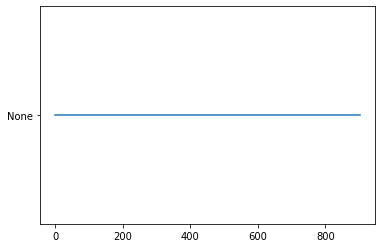

100%|██████████| 903/903 [00:00<00:00, 75256.95it/s]


[('NI',), ('CR',), ('FE',), ()]


100%|██████████| 903/903 [00:00<00:00, 56438.23it/s]

In [36]:
def getLiquidusTempforPoints(models = Models, phaseNames = PhaseNames):
    LiquidusTemp = []
    failList2 = []
    for index in range(numFile):
        if index not in failList:
            phases = phaseNames[index]
            hasLiquid = False
            for item in phases:
                if 'LIQUID' in item:
                    hasLiquid = True
                    break
            if not hasLiquid:
                print(f'Upper temperature for {index}th composition is too low, no liquid')
                LiquidusTemp.append('None')
                failList2.append(index)
            else:
                T = [item for item in range(TRange[0], TRange[1], TRange[2])]
                LiquidRelatedPhase = []
                for item in phases:
                    if 'LIQUID' in item:
                        LiquidRelatedPhase.append(item)
                phaseAmounts = models[index].predict(np.array(T).reshape(-1, 1))
                liquid_indexs = []
                for item in LiquidRelatedPhase:
                    liquid_indexs.append(phases.index(item))
                liquidAmount = [] 
                for item in phaseAmounts:
                    totalLiquid = 0
                    for liquid_index in liquid_indexs:
                        totalLiquid += item[liquid_index]
                    liquidAmount.append(totalLiquid)
                liquidSuccessfullyFind = False
                i = 0
                for item in liquidAmount:
                    if item < 1:
                        i += 1
                    else:
                        LiquidusTemp.append(T[i])
                        liquidSuccessfullyFind = True
                        break
                if not liquidSuccessfullyFind:
                    print(f'Upper temperature for {index}th composition is too low, no 100% liquid')
                    LiquidusTemp.append('None')
                    failList2.append(index)
        else:
            LiquidusTemp.append('None')
    return LiquidusTemp, failList2
LiquidusTemp, failList2 = getLiquidusTempforPoints(models = Models, phaseNames = PhaseNames)
print(f'{len(failList2)} files failed. FailList:')
print(failList2)
plt.plot(LiquidusTemp)
plt.show()
def sortCompositions(Compositions): 
    output = []
    lackEle_original = []
    for index in tqdm(range(len(Compositions['Index']))):
        tempt = []
        keys = [item for item in Compositions.keys()]
        for key in keys:
            if key != 'Index' and 'Unnamed' not in key and 'Temperature' not in key and 'alloy' not in key:
                if round(Compositions[key][index],5) == 0:
                    tempt.append(key)
        lackEle_original.append(tuple(tempt))
    # lackEle = [item for item in set(lackElelackEle_original)]
    lackEle = []
    for item in set(lackEle_original):
        if len(item) < len(settings[3]) - 1: # meaningless to do Scheil for pure element
            lackEle.append(item)
    print(lackEle)
    for index_lackEle in range(len(lackEle)):
        Elelist = {}
        for key in keys:
            if 'Unnamed' not in key:
                Elelist[key] = []
        output.append(Elelist)
    for index in tqdm(range(len(Compositions['Index']))):
        tempt = []
        for key in keys:
            if key != 'Index' and 'Unnamed' not in key and 'Temperature' not in key and 'alloy' not in key:
                if round(Compositions[key][index],5) == 0:
                    tempt.append(key)
        if len(tempt) < len(settings[3])-1:
            tempt = tuple(tempt)   
            ii = lackEle.index(tempt)
            for key in keys:
                if 'Unnamed' not in key :
                    output[ii][key].append(Compositions[key][index])
    return output

def findMainElement(compositions, elements, index):
    fraction = []
    for ele in elements:
        fraction.append(round(compositions[ele][index],5))
    return elements[fraction.index(max(fraction))]

def createScheilScript():
    comp = settings[3]
    path = f'./Simulation/{date}'
    Compositions = {}
    for key in data.columns:
        Compositions[key] = data[key].values
    output = sortCompositions(Compositions)
    isExist = os.path.exists(path + '/Scheil Simulation')
    if not isExist:
        os.makedirs(path + '/Scheil Simulation')
        print("The new directory is created!")
    index_compositionList = 0
    for Compositions in output:
        compositions = {}
        for ele in comp:
            compositions[ele] = Compositions[ele]
        Indexs = Compositions['Index']
        f = open(path + '/Scheil Simulation' + '/' + output_Scheil + f'-{index_compositionList}_0.TCM', 'w')
        numSimulation = 0
        numFile = 0
        for index in range(len(Indexs)):
            if LiquidusTemp[Indexs[index]] != 'None':
                startTemp = LiquidusTemp[Indexs[index]] + 25
            else:
                startTemp = backupStartTemp
            f.write('SET_ECHO\n\n\n')
            f.write('GO SCHEIL\n')
            if GlobalMinimization:
                f.write('global_minimization\n')
                f.write('Y\n')
            f.write('TERMINATION_CRITERIA\n')
            f.write('F\n')
            f.write(f'{finalLiquidFraction}\n')
            f.write('set-numerical-limits\n')
            f.write(f'{iterationNum}\n\n\n\n')
            f.write('TEMPERATURE-STEP\n')
            #set temperature step
            f.write(f'{temperatureStep}\n')
            f.write('START-WIZARD\n')
            if database[-3:].upper() != 'TDB':
                f.write(database)
            else:
                f.write('user ' + database)
            mainEle = findMainElement(compositions, comp, index)
            f.write('\n')
            f.write(f'{mainEle}\n')
            #use mass percent
            f.write('y\n')
            includedEles = [mainEle]
            for ele in comp:
                if ele != mainEle and round(compositions[ele][index] * 100, 8) != 0:
                    includedEles.append(ele)
                    f.write(f'{ele}\n')
                    f.write(f'{round(compositions[ele][index] * 100, 8)}\n') #should be in mass percent
            f.write('\n')
            f.write(f'{startTemp}\n')
            if rejectPhase:
                f.write(f'{Phases}\n')
                f.write(f'NONE\n')
            if not rejectPhase:
                f.write('*\n')
                if not retainPhase:
                    f.write('*\n')
                else:
                    f.write(f'{Phases}\n')
            f.write('NONE\n')
            f.write('y\n')
            if  miscibilityGap:
                f.write('y\n')
                f.write(f'{miscibilityGapPhase}\n')
                f.write(f'\n')
                f.write(f'\n')
            if not miscibilityGap:
                f.write('N\n')
            if fastDiffusing and fastDiffusingComp in includedEles:
                f.write(f'{fastDiffusingComp}\n')
            else:
                f.write('NONE\n')
            f.write('s-d-a x t\n')
            f.write('s-d-a y NL\n')
            f.write('plot\n')
            f.write('m-e\n')
            f.write(f'{Indexs[index]}_liquid_mol%.exp'+'\n')
            f.write('s-d-a y NS(*)\n')
            f.write('plot\n')
            f.write('m-e\n')
            f.write(f'{Indexs[index]}_solid_mol%.exp'+'\n')
            f.write('s-d-a y BS(*)\n')
            f.write('plot\n')
            f.write('m-e\n')
            f.write(f'{Indexs[index]}_solid_wt%.exp'+'\n')
            f.write('s-d-a y BL\n')
            f.write('plot\n')
            f.write('m-e\n')
            f.write(f'{Indexs[index]}_liquid_wt%.exp'+'\n')
            f.write('s-d-a y W(*,*)\n')
            f.write('\n')
            f.write('plot\n')
            f.write('m-e\n')
            f.write(f'{Indexs[index]}_composition_wt%.exp'+'\n')
            if index == numFile -1:
                f.write('set-inter\n')
            else:
                f.write('back\n')
                f.write('back\n')
            numSimulation += 1
            if numSimulation >= maxNumSim:
                numFile += 1
                f.close()
                numSimulation = 0
                f = open(path + '/Scheil Simulation' + '/' + output_Scheil + f'-{index_compositionList}_{numFile}.TCM', 'w')
        f.close()
        index_compositionList += 1
createScheilScript()